
# Final Project - Comments analysis and prediction


Online comments contain a wealth of valuable information. Sentiment analysis is an important tool that helps analysts understand users' emotion. In addition, the people's ways of speaking are sometimes different from normal lifestyles when chatting online or posting comments.


The final project implements sentiment analysis and text prediction according to the comments. 


The reference is [Github][1]

[1]: https://github.com/nagypeterjob

In [124]:
#import libraries
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import random
import sys
import io
import re
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

# sentiment analysi

Load the data

In [157]:
data = pd.read_csv('comment.csv')
#select the neccessary columns
data = data[['sentiment','text']]
#remove na value
data=data.dropna()

Chech the data if it loaded correctly

In [158]:
data.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [159]:
#remove the unnecessary word 
lines = []
for line in data[ 'text']:
    line=line.replace('RT',' ')
    lines.append(line)
data[ 'text']=lines  

In [160]:
data

,sentiment,text
0,Neutral,@NancyLeeGrahn: How did everyone feel about ...
1,Positive,@ScottWalker: Didn't catch the full #GOPdeba...
2,Neutral,@TJMShow: No mention of Tamir Rice and the #...
3,Positive,@RobGeorge: That Carly Fiorina is trending -...
4,Positive,@DanScavino: #GOPDebate w/ @realDonaldTrump ...
5,Positive,"@GregAbbott_TX: @TedCruz: ""On my first day I..."
6,Negative,@warriorwoman91: I liked her and was happy w...
7,Neutral,Going on #MSNBC Live with @ThomasARoberts arou...
8,Negative,Deer in the headlights @lizzwinstead: Ben Ca...
9,Negative,@NancyOsborne180: Last night's debate proved...


Show the frequent words by using WordCloud 

In [161]:
def draw_wordcloud(data, color):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('#') and not word.startswith('@')
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=color, width=1500,height=1000).generate(cleaned_word)

    plt.figure(1,figsize=(12, 12))  
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

Positive Words


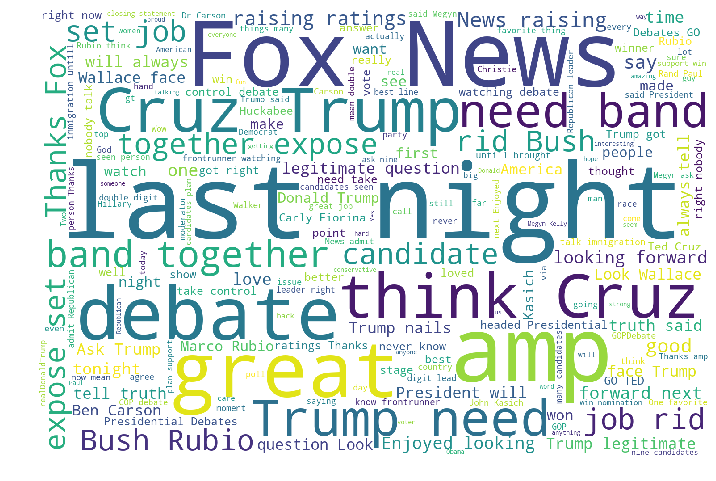

Neutral Words


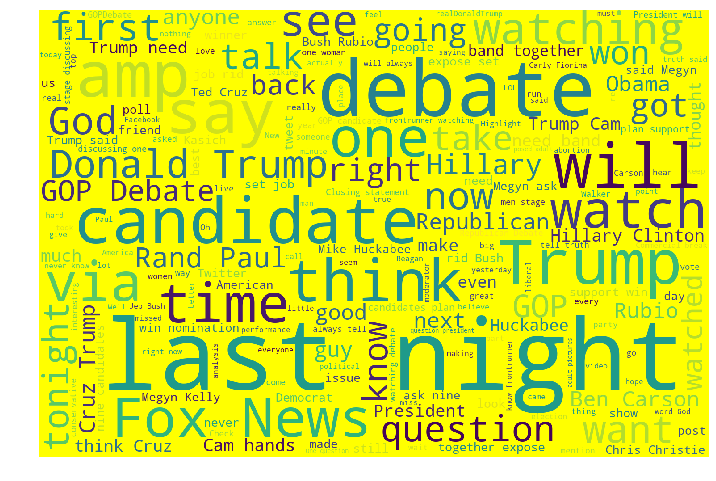

Negative Words


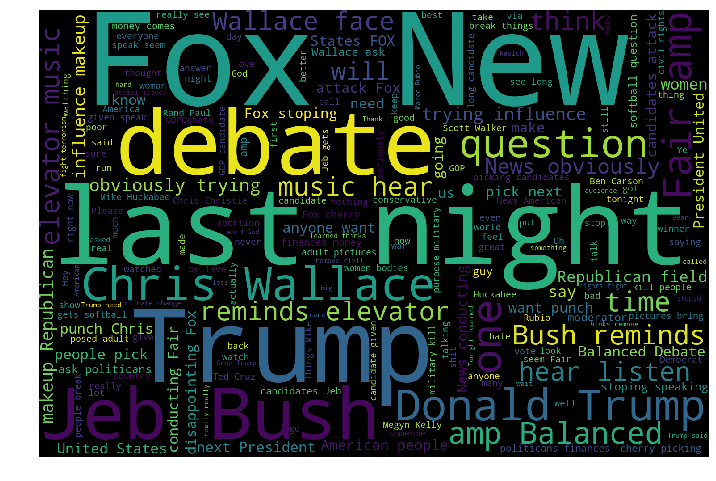

In [162]:
positive = data[ data['sentiment'] == 'Positive']
positive = positive['text']
neutral = data[ data['sentiment'] == 'Neutral']
neutral = neutral['text']
negative = data[ data['sentiment'] == 'Negative']
negative = negative['text']

print("Positive Words")
draw_wordcloud(positive,'white')
print("Neutral Words")
draw_wordcloud(neutral,'yellow')
print("Negative Words")
draw_wordcloud(negative,'black')

Preprocessing and building tokenizer

In [190]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

tokenizer = Tokenizer(nb_words=1000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

In [191]:
data

,sentiment,text
0,Neutral,nancyleegrahn how did everyone feel about th...
1,Positive,scottwalker didnt catch the full gopdebate l...
2,Neutral,tjmshow no mention of tamir rice and the gop...
3,Positive,robgeorge that carly fiorina is trending ho...
4,Positive,danscavino gopdebate w realdonaldtrump deliv...
5,Positive,gregabbott_tx tedcruz on my first day i will...
6,Negative,warriorwoman91 i liked her and was happy whe...
7,Neutral,going on msnbc live with thomasaroberts around...
8,Negative,deer in the headlights lizzwinstead ben cars...
9,Negative,nancyosborne180 last nights debate proved it...


Preprocessing of training data and testing data

In [196]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)
print(data[ data['sentiment'] == 'Neutral'].size)

4472
16986
6284


Build the model by using LSTM

In [197]:
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(1000, 128, input_length = X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.8), metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 28, 128)           128000    
_________________________________________________________________
dropout_32 (Dropout)         (None, 28, 128)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 771       
Total params: 523,011
Trainable params: 523,011
Non-trainable params: 0
_________________________________________________________________
None


Split the dataset into 70% training set and 30% testing set

In [198]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9709, 28) (9709, 3)
(4162, 28) (4162, 3)


Train the model

In [199]:
hist=model.fit(X_train, Y_train, nb_epoch = 10, batch_size=16, validation_split=0.2)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 7767 samples, validate on 1942 samples
Epoch 1/10
7767/7767 [==============================] - 35s 5ms/step - loss: 0.9205 - acc: 0.6091 - val_loss: 0.8623 - val_acc: 0.6123
Epoch 2/10
7767/7767 [==============================] - 31s 4ms/step - loss: 0.8325 - acc: 0.6207 - val_loss: 0.8225 - val_acc: 0.6483
Epoch 3/10
7767/7767 [==============================] - 32s 4ms/step - loss: 0.7817 - acc: 0.6591 - val_loss: 0.7887 - val_acc: 0.6674
Epoch 4/10
7767/7767 [==============================] - 32s 4ms/step - loss: 0.7417 - acc: 0.6739 - val_loss: 0.7837 - val_acc: 0.6720
Epoch 5/10
7767/7767 [==============================] - 32s 4ms/step - loss: 0.7127 - acc: 0.6846 - val_loss: 0.7746 - val_acc: 0.6648
Epoch 6/10
7767/7767 [==============================] - 29s 4ms/step - loss: 0.6913 - acc: 0.6973 - val_loss: 0.7780 - val_acc: 0.6684
Epoch 7/10
7767/7767 [==============================] - 32s 4ms/step - loss: 0.6742 - acc: 0.7093 - val_loss: 0.7818 - val_acc: 0.6648
Epoch 8

In [200]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score is:', score[0])
print('Test accuracy is:', score[1])

Test score is: 0.7772964596146864
Test accuracy is: 0.664103796251802


Visualize the accuracy of the model

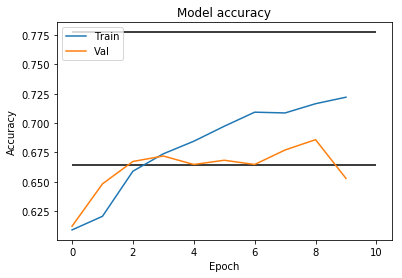

In [201]:
plt.hlines(score,0,10)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Visualize the models loss

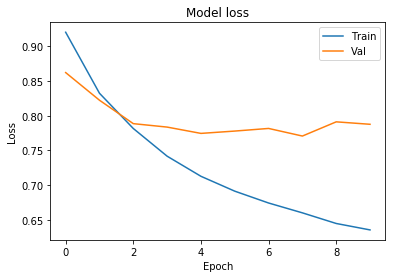

In [202]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Text prediction

In [262]:
maxlen = 50
text=''
for line in data['text']:
    text=text+line+'\n'

Classify characters

In [263]:
chars = sorted(list(set(text)))

Build the necessary query tables

In [264]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Create input and label text

In [265]:
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, 3):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

In [266]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Build the text prediction model

In [267]:
from keras.optimizers import RMSprop
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 128)               89088     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 45)                5805      
Total params: 94,893
Trainable params: 94,893
Non-trainable params: 0
_________________________________________________________________
None


Choose a example for prediction

In [268]:
def extractsample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

This function is used to print generated prediction text after each epoch

In [269]:
def printprediction(epoch, _):
    print()
    print('------------------------')
    print()
    print('Epoch: %d' % epoch)
    #randomly choose a start index to extract the sample
    start_index = random.randint(0, len(text) - maxlen - 1)
    #generate the words
    prediction = ''
    sentence = text[start_index: start_index + maxlen]
    prediction=prediction+sentence
    print('The example is: "' + sentence + '"')
    print('The prediction is:')
    sys.stdout.write(prediction)
    #find out the following words according to the model
    for i in range(50):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = extractsample(preds)
        next_char = indices_char[next_index]
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Print the prediction

In [270]:
printafterepoch = LambdaCallback(on_epoch_end=printprediction)
model.fit(x, y, batch_size=256, epochs=10, callbacks=[printafterepoch])

Epoch 1/10
494209/494209 [==============================] - 362s 732us/step - loss: 1.8142

------------------------

Epoch: 0
The example is: "d yesterdays gopdebate todays work tunes stayinfor"
The prediction is:
d yesterdays gopdebate todays work tunes stayinfort
chris the bets ageserags retessmay or has the ne
Epoch 2/10
494209/494209 [==============================] - 362s 732us/step - loss: 1.5010

------------------------

Epoch: 1
The example is: " not conducting a fair amp balanced debate  gopdeb"
The prediction is:
 not conducting a fair amp balanced debate  gopdebate  httpst
  monaldary can cosclost likas nivin 

Epoch 3/10
494209/494209 [==============================] - 362s 733us/step - loss: 1.4463

------------------------

Epoch: 2
The example is: "man is seriously irritating me with his bias tcot "
The prediction is:
man is seriously irritating me with his bias tcot tleate christie major agreat leasator camay fox ne
Epoch 4/10
494209/494209 [==========================

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


  gopdebates
  meribrs we ha
Epoch 10/10
494209/494209 [==============================] - 520s 1ms/step - loss: 1.3486

------------------------

Epoch: 9
The example is: "e
httpstcovvia1nuyld via youtube
  mojowhoha check"
The prediction is:
e
httpstcovvia1nuyld via youtube
  mojowhoha checking gopdebate
  joliangem was wis will piging who 


According to the result, there were many spelling mistakes in the prediction text at first. 
However, the model become more and more smart after several epochs.
The spelling is much improved and the prediction text is much similar to a real comment.